# Tutorial: First Guess

#### June 2023

In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import os 
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
from core.engine import preprocess, first_guess, get_metrics

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2023-07-18 19:17:07.313444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 19:17:07.811805: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://

The first step is to preprocess the data, which involves normalizing the PSF, cropping windows centered on candidate companions, and obtaining the initial parameters from the VIP library. In order to accomplish this, we employ the `preprocess()` function as follows:

In [4]:
%%time
window_size = 50
data_path = './data/real/f_dhtau/'
table, cube, psf, rot_angles, backmoments = preprocess(data_path)
dataset_name = data_path.split('/')[-2]
dataset_name

CPU times: user 1.97 s, sys: 1.6 s, total: 3.57 s
Wall time: 3.45 s


'f_dhtau'

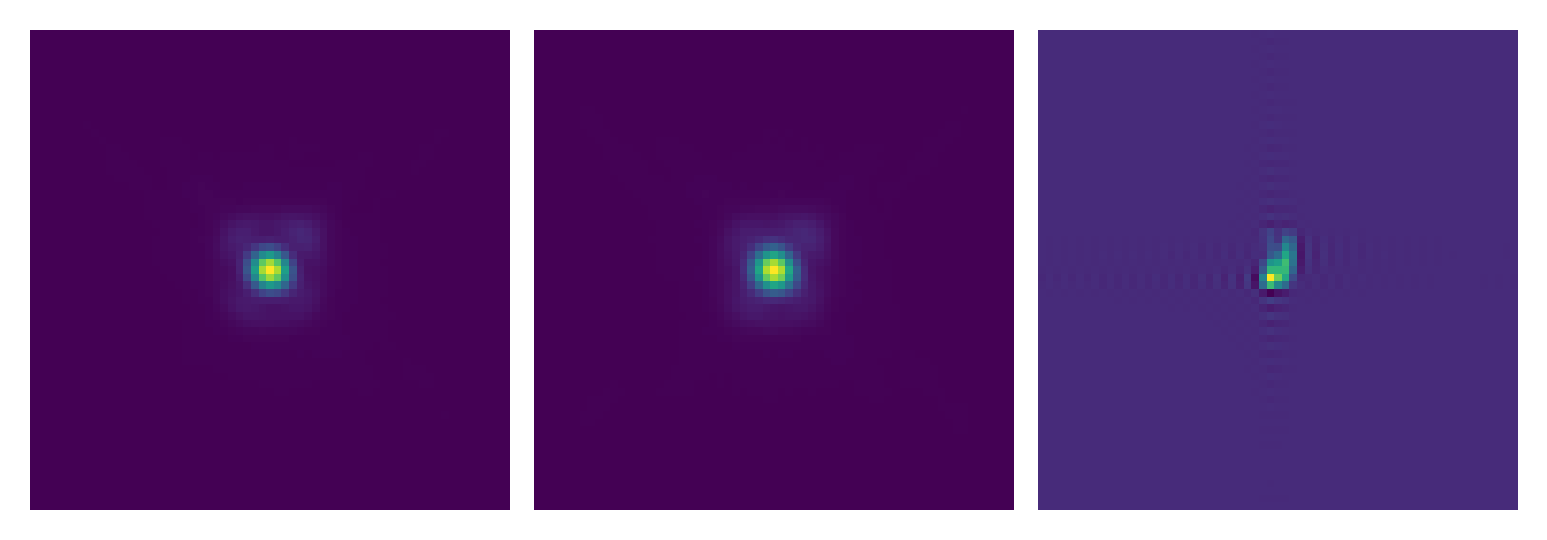

In [5]:
fig, axes = plt.subplots(1, len(psf), dpi=300,
                        gridspec_kw={'hspace': 0, 'wspace': 0.05})

for i, p in enumerate(psf):
    axes[i].imshow(p)
    axes[i].axis('off')
    
psf_filtered = psf[:2]

The following files should be located within the dataset folder (`./data/real/f_dhtau` in this example), using exactly the same names:
- `centered_im.fits`: cube
- `median_unsat.fits`: psf
- `rotnth.fits`: rotation angles

If it is the first time we run the preprocess function, it will compute PCA+ADI using VIP and then store the preprocessed data to avoid preprocessing the dataset again.

We first filter our table to maintain only the coordinates we want to fit.

In [6]:
table = table[table['snr']>2]
table

,x,y,flux,fwhm_mean,snr
0,384.839338,366.860187,278.385232,4.127939,68.267050
1,385.998693,727.507117,128.015363,4.261339,80.891019
4,548.480908,731.764102,1.652026,4.809203,19.143805


Next, we will use the first_guess function to fit our parameters

In [163]:
%%time
first_guess(table, cube, psf_filtered, 
             backmoments=backmoments,
             window_size=window_size, 
             learning_rate=1e-0, 
             epochs=1e6,
             target_folder='./logs/{}'.format(dataset_name),
             verbose=0,
             loss_precision=0.)

[INFO] Training (x, y) = (384.84 366.86)


2023-07-17 15:34:44.407666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 15:34:44.428390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 15:34:44.436623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

[INFO] Training (x, y) = (386.00 727.51)
[INFO] Training (x, y) = (548.48 731.76)
CPU times: user 16.3 s, sys: 734 ms, total: 17 s
Wall time: 18 s


,index,x,y,flux,fwhm_mean,snr,optimal_flux
0,0,384.839338,366.860187,278.385234,4.127939,68.267040,328.594086
1,1,385.998693,727.507117,128.015367,4.261340,80.891006,146.333588
2,4,548.480908,731.764104,1.652023,4.809200,19.143808,1.641381


## Visualizing results

In [231]:
from core.engine import inference_step

In [232]:
table_op = pd.read_csv(os.path.join(f'./logs/{dataset_name}','prediction.csv'))
table_op

,index,x,y,flux,fwhm_mean,snr,optimal_flux
0,0,97.736452,97.652952,15.454206,3.057851,2.315319,1309.295654
1,1,90.979735,87.349373,31.502242,4.559094,4.930585,44.860153
2,2,107.778100,96.231150,10.873399,5.207005,2.145639,-459.570312


95.67268013954163
95.67259502410889
95.67258095741272
95.6725959777832
0.5642049312591553
0.5642709732055664
0.5643188953399658
0.5644528865814209
29.644052982330322
29.644043922424316
29.644043922424316
29.64407706260681


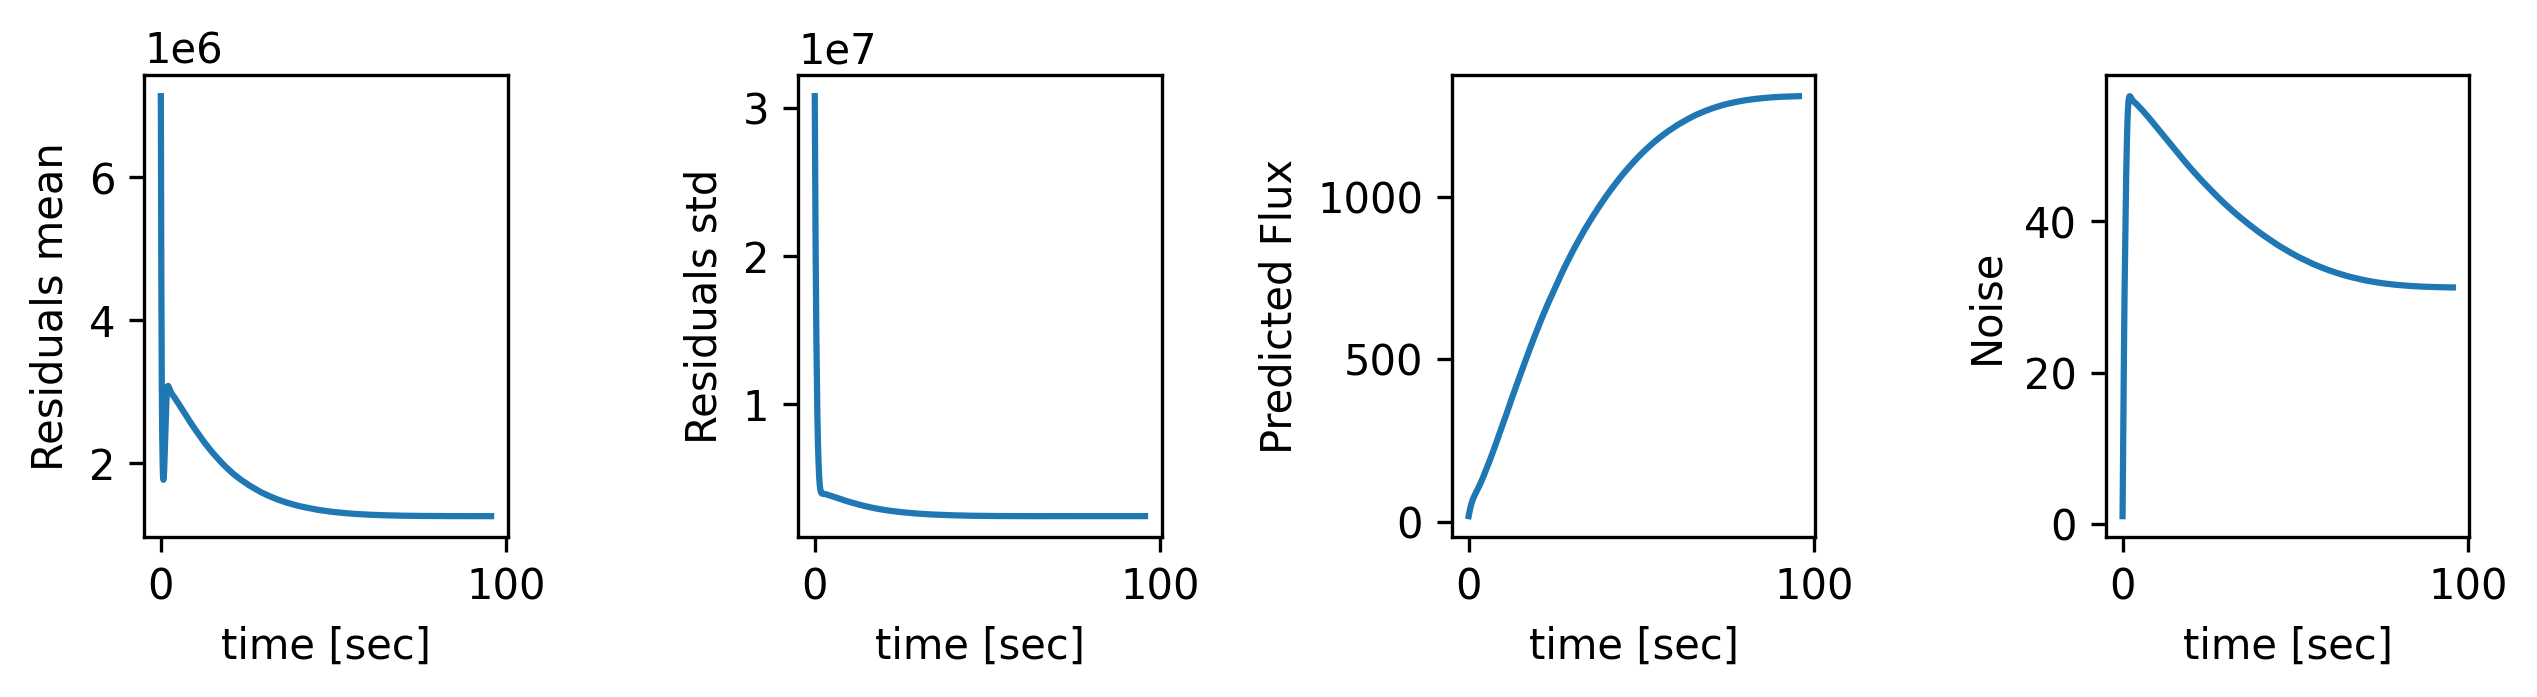

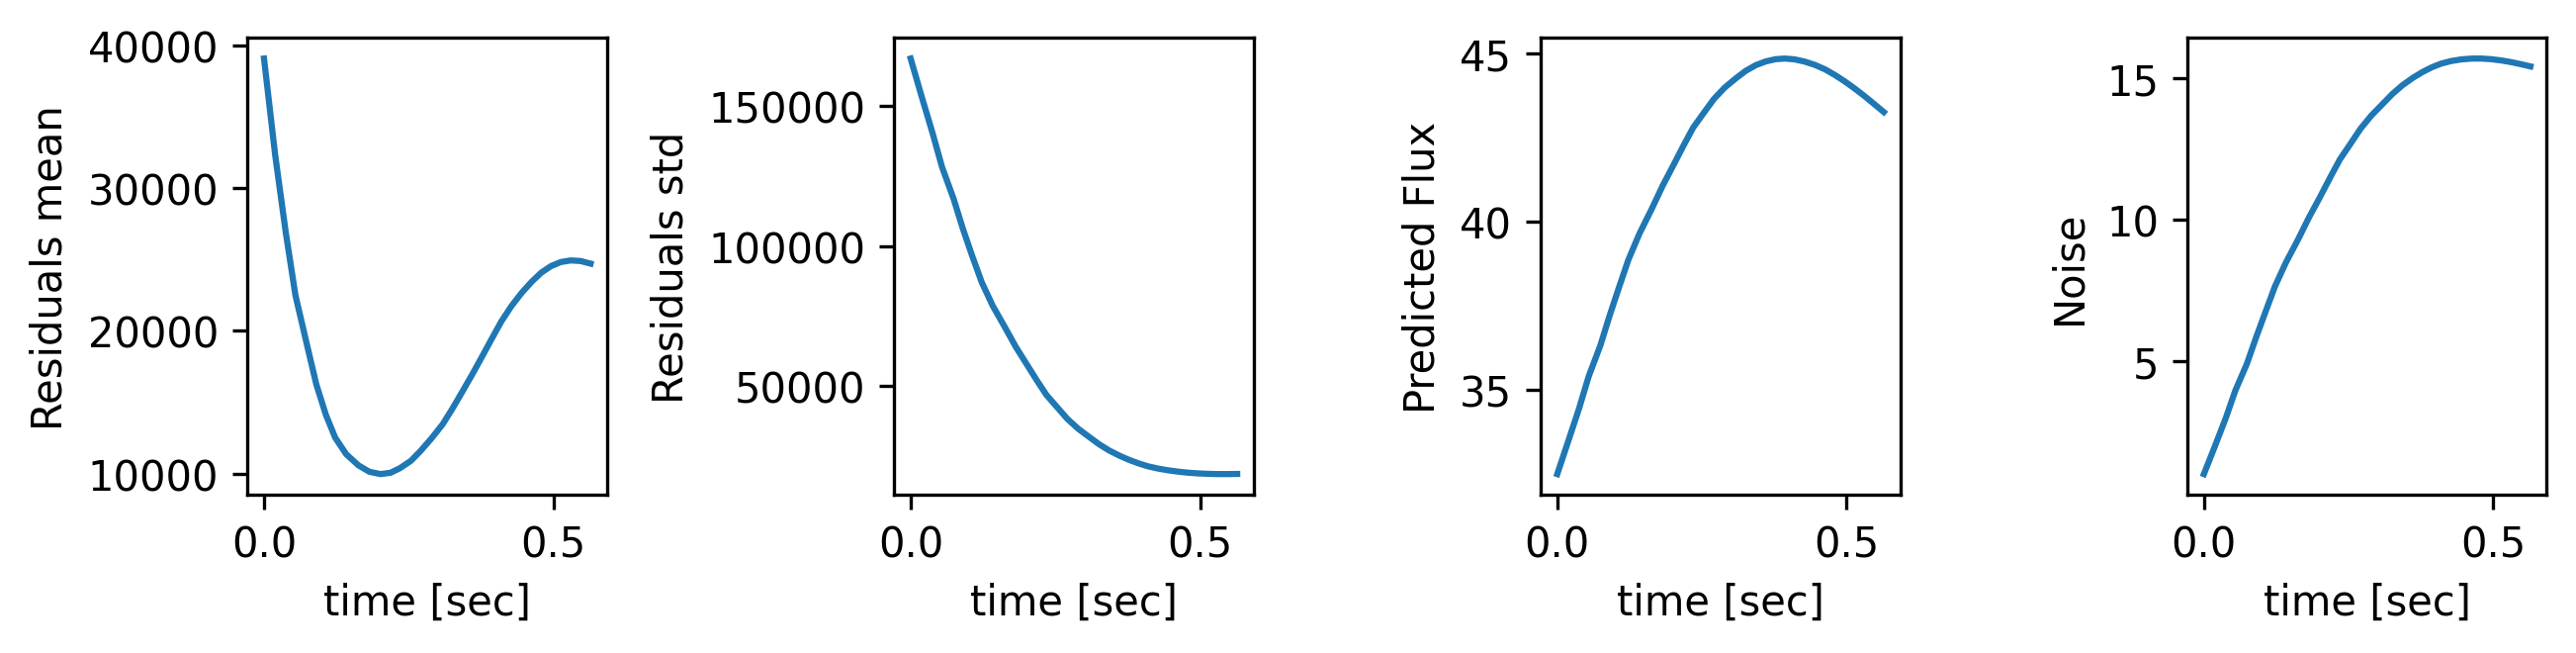

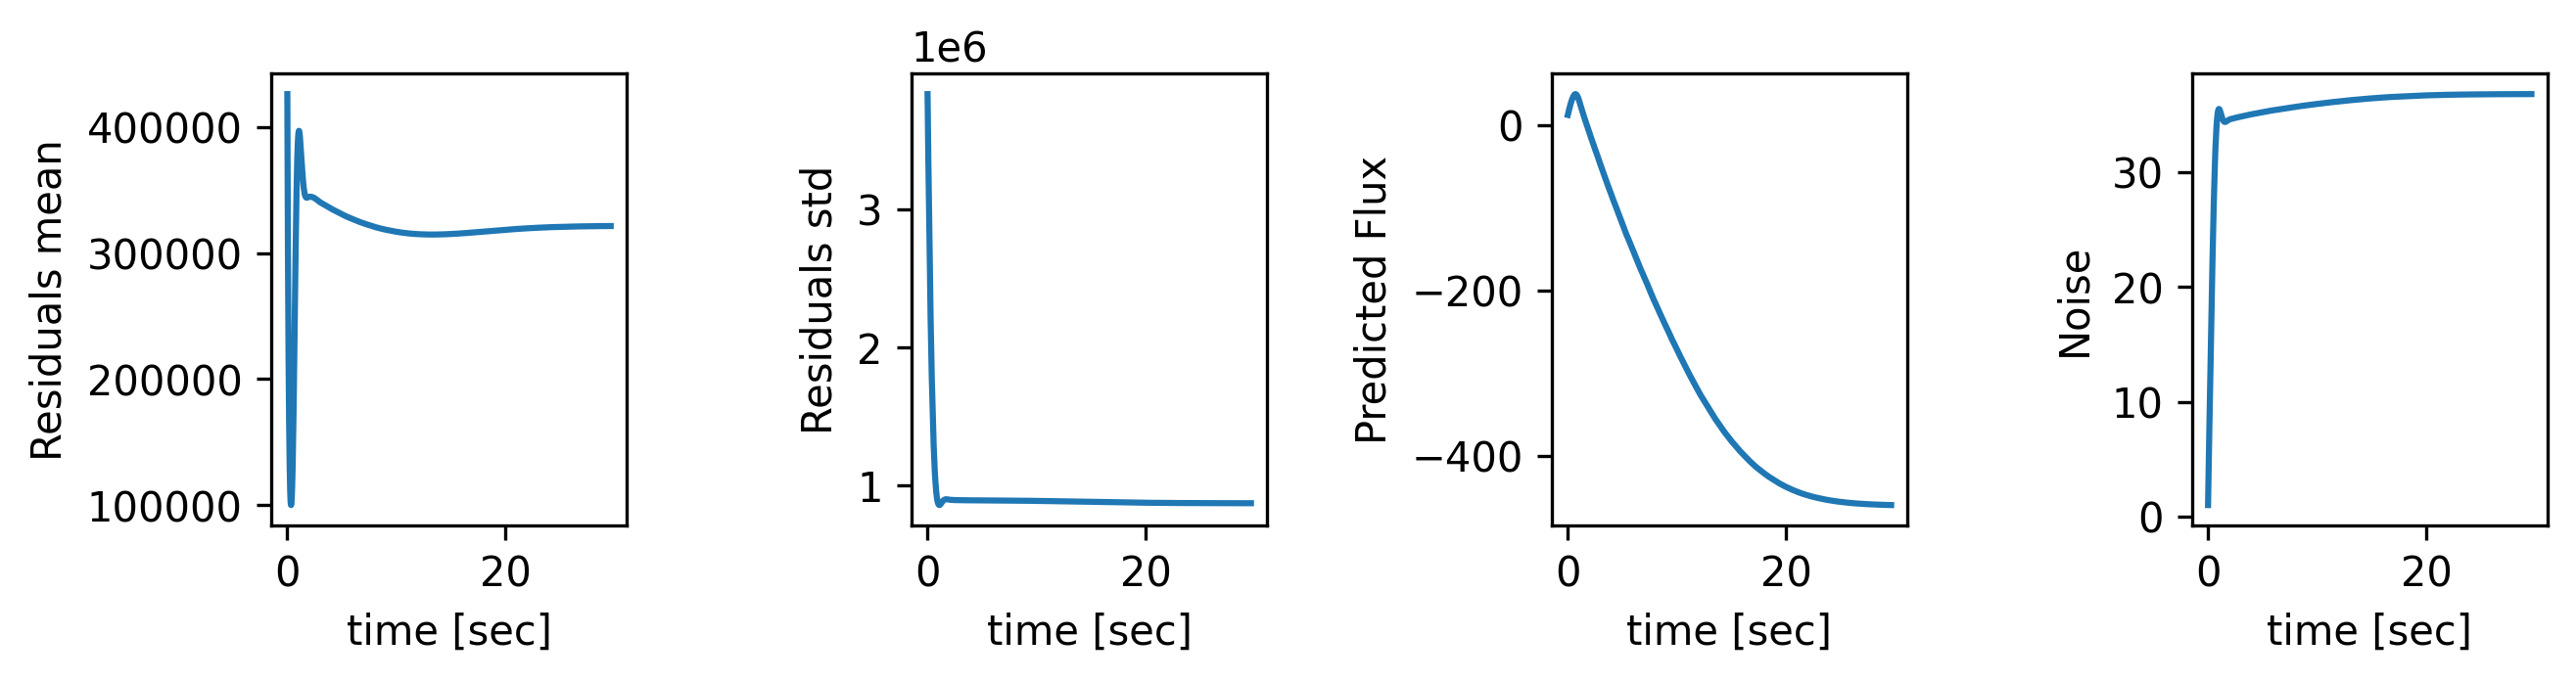

In [233]:
for index, row in table_op.iterrows():
    model_path = f"./logs/{dataset_name}/model_{row['index'].astype(int)}/"

    fig, axes = plt.subplots(1, 4, figsize=(10, 2), dpi=300,
                             gridspec_kw={'hspace': 0, 'wspace': 0.8})

    ylabels = ['Residuals mean', 'Residuals std', 'Predicted Flux', 'Noise']
    for i, metric in enumerate(['epoch_res_mean', 'epoch_res_std', 'epoch_flux', 'epoch_noise']):
        train_metrics = get_metrics(f'{model_path}/logs/train/', show_keys=False, metric_name=metric)

        time = (train_metrics['wall_time'].values -train_metrics['wall_time'].values[0]) 
        print(time[-1])
        axes[i].plot(time, train_metrics['value'].values)
        axes[i].set_xlabel('time [sec]')
        axes[i].set_ylabel(ylabels[i])

In [234]:
table_op

,index,x,y,flux,fwhm_mean,snr,optimal_flux
0,0,97.736452,97.652952,15.454206,3.057851,2.315319,1309.295654
1,1,90.979735,87.349373,31.502242,4.559094,4.930585,44.860153
2,2,107.778100,96.231150,10.873399,5.207005,2.145639,-459.570312


In [235]:
index = 1
model_path = f"./logs/{dataset_name}/model_{index}/"

selected = table_op[table_op['index'] == index]
fake_comp, real_comp, fluxes, model = inference_step(cube, 
                                     psf_filtered, 
                                     selected['x'].values, 
                                     selected['y'].values, 
                                     model_path=model_path, 
                                     window_size=window_size)
dydx_shift_coords = model.trainable_variables[-1]
model_path

2023-07-17 16:24:08.833327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 16:24:08.833341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 16:24:08.889018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

1/1 [==============================] - 0s 100ms/step


'./logs/HCI/model_1/'

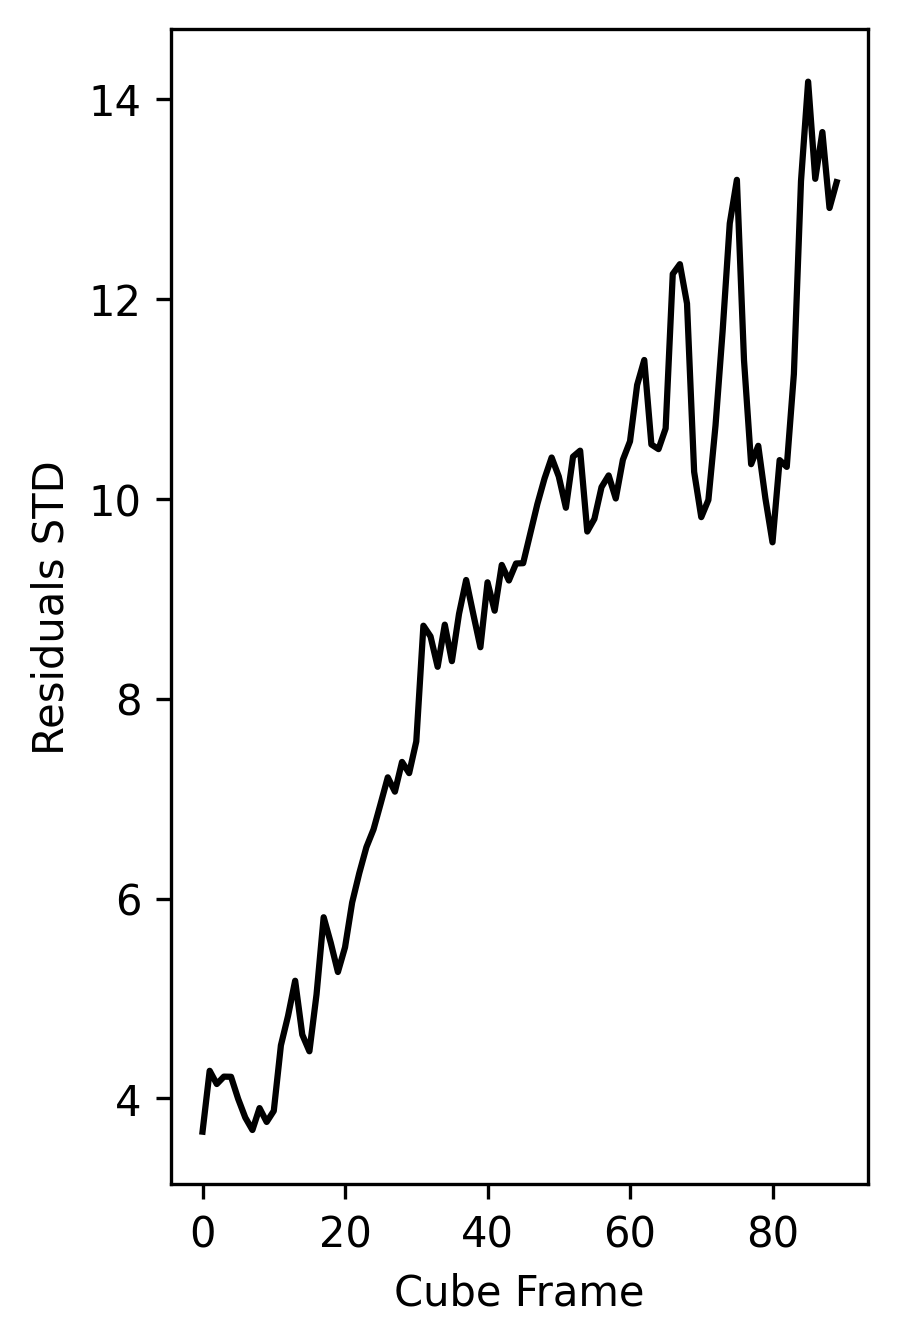

In [236]:
Ntotal = fake_comp.shape[0]
fs = 15

stds = []
for N in range(Ntotal):
    residuals = real_comp[N] - fake_comp[N]
    std_res = np.std(residuals)
    stds.append(std_res)
    
plt.figure(figsize=(3,5), dpi=300)
plt.plot(stds, color='k')
plt.xlabel('Cube Frame')
plt.ylabel('Residuals STD')
plt.show()

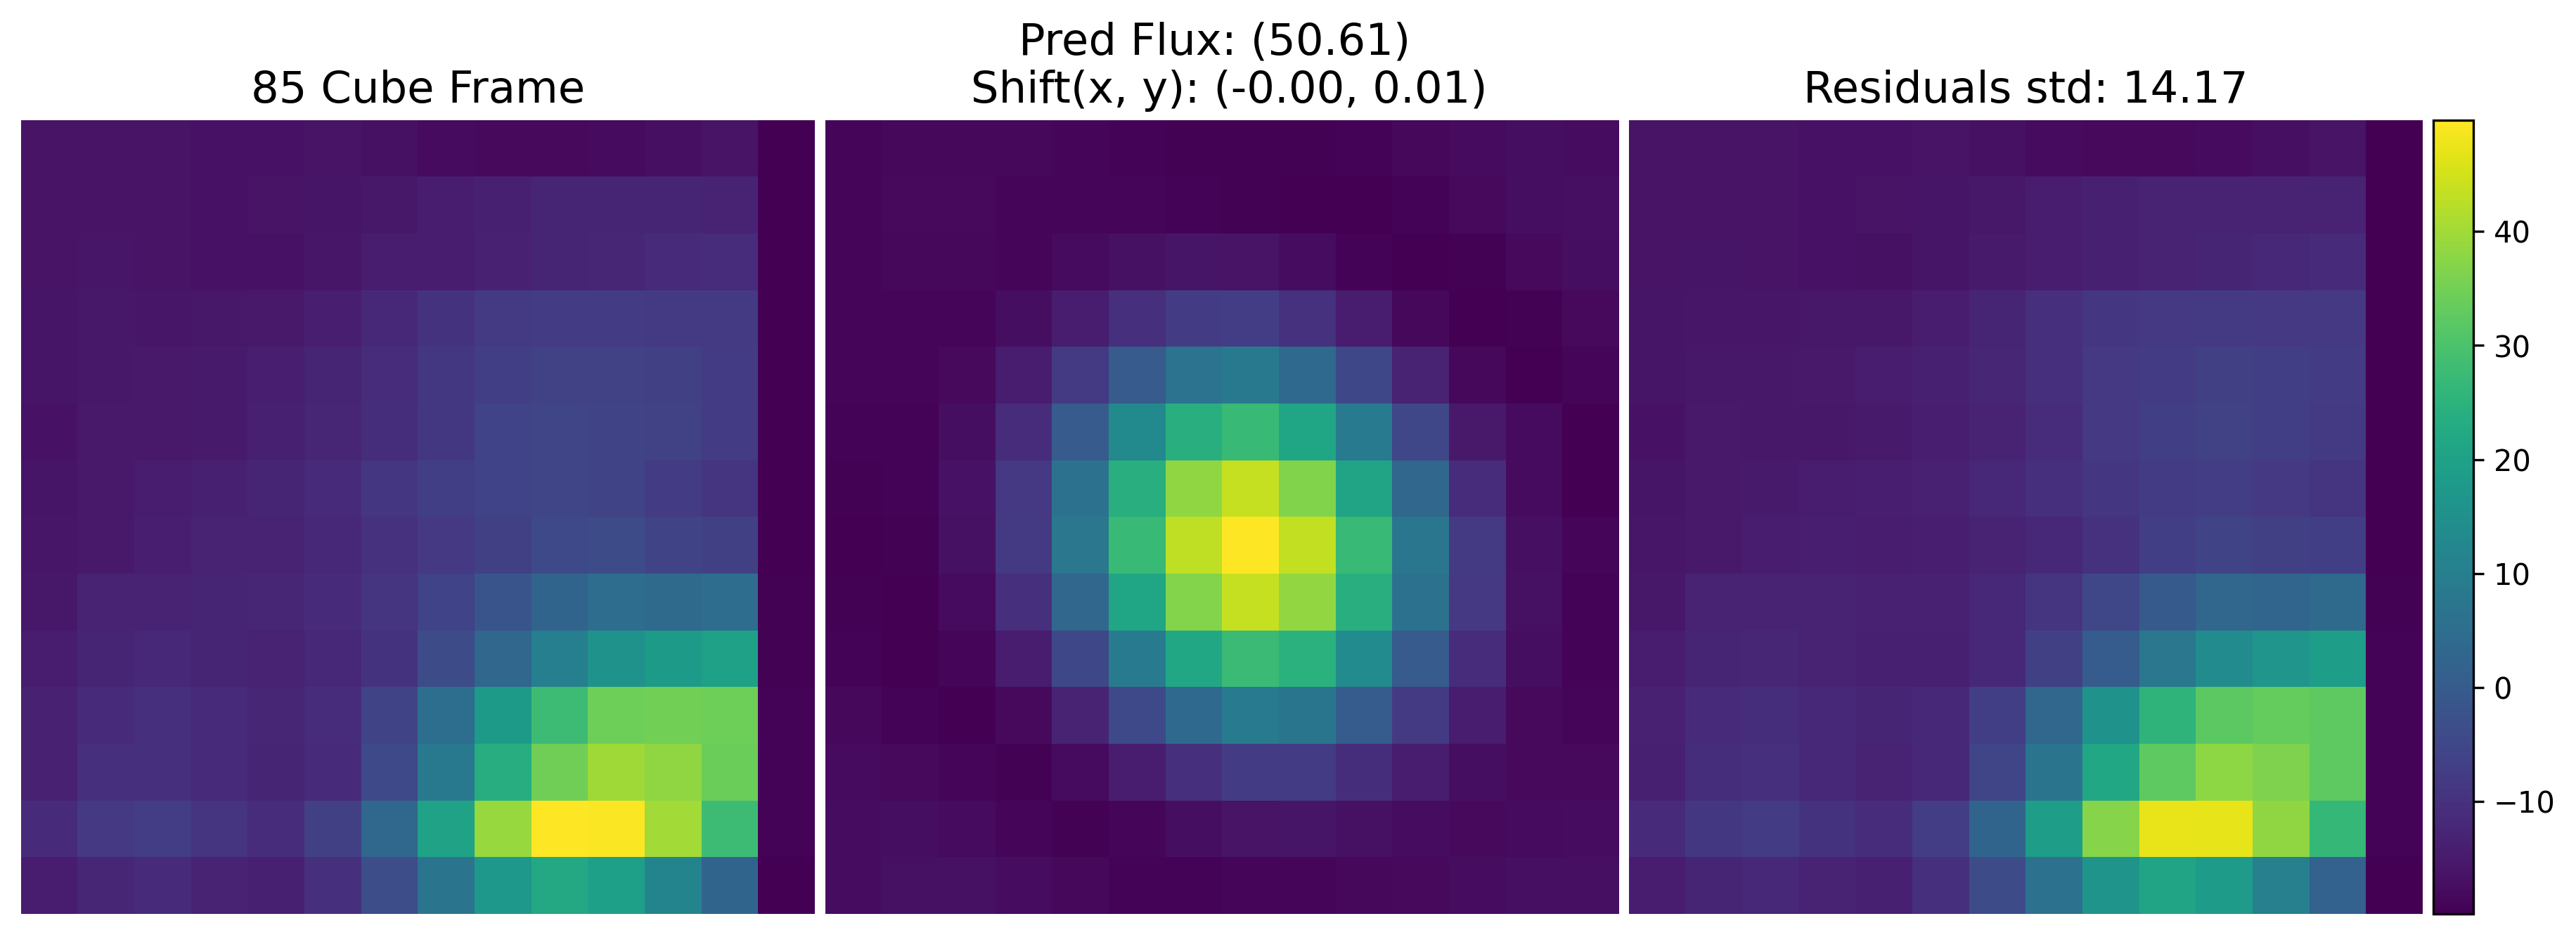

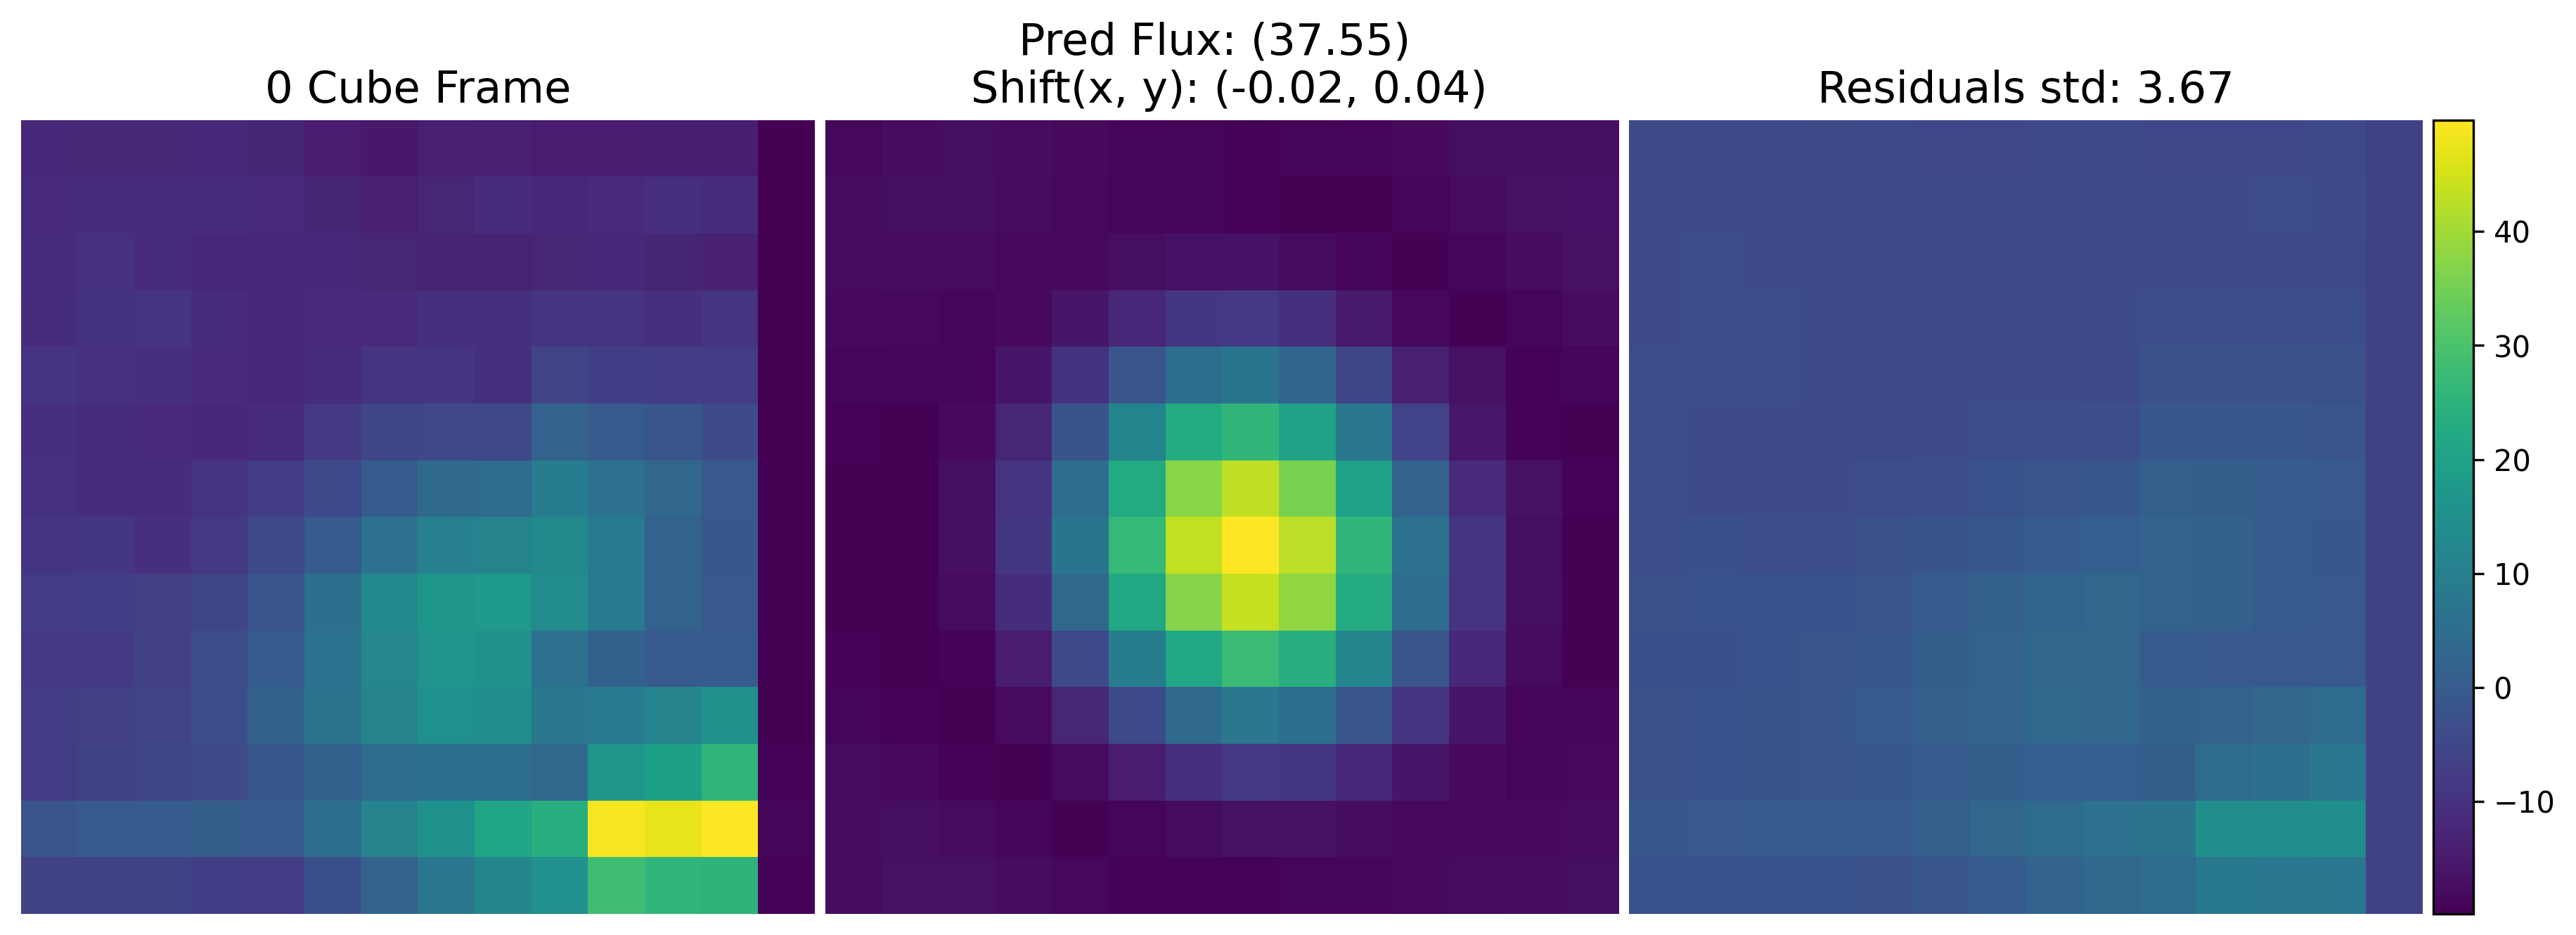

In [237]:
os.makedirs(os.path.join(model_path, 'results'), exist_ok=True)
residuals = real_comp-fake_comp
vmin = residuals.min()
vmax = residuals.max()
for N in [np.argmax(stds), np.argmin(stds)]:
    
    fig = plt.figure(dpi=300, figsize=(15, 15))
    axes = ImageGrid(fig, 111,
                    nrows_ncols = (1, 3),
                    axes_pad = 0.05,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.05
                    )
    
    axes[0].imshow(real_comp[N])#, vmin=vmin, vmax=vmax)
    axes[0].set_title(f'{N} Cube Frame', fontsize=fs)
    axes[0].axis('off')

    axes[1].imshow(fake_comp[N])#, vmin=vmin, vmax=vmax)
    axes[1].set_title('Pred Flux: ({:.2f}) \n Shift(x, y): ({:.2f}, {:.2f})'.format(fluxes[N], 
                                                                          dydx_shift_coords[N][1],
                                                                          dydx_shift_coords[N][0]), 
                         fontsize=fs)
    axes[1].axis('off')
    
    im = axes[2].imshow(residuals[N], vmin=vmin, vmax=vmax)
    axes[2].set_title('Residuals std: {:.2f}'.format(np.std(residuals[N])), fontsize=fs)
    axes[2].axis('off')

    fig.colorbar(im, cax=axes.cbar_axes[0])
    fig.savefig(os.path.join(model_path, 'results', f'{N}.png'), format='png', bbox_inches='tight')

# Visualizing on whole image 

In [238]:
from vip_hci.preproc.derotation import cube_derotate
from vip_hci.fm import cube_inject_companions
from vip_hci.config import VLT_SPHERE_IFS
from vip_hci.psfsub import pca

from core.engine import get_angle_radius, pca_tf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
index = 1
model_path = f"./logs/HCI/model_{index}"

table_opt = pd.read_csv(os.path.join(model_path,'..','prediction.csv'))
table_opt

,index,x,y,flux,fwhm_mean,snr,optimal_flux
0,0,97.736452,97.652952,15.454206,3.057851,2.315319,1309.295654
1,1,90.979735,87.349373,31.502242,4.559094,4.930585,44.860153
2,2,107.778100,96.231150,10.873399,5.207005,2.145639,-459.570312


In [242]:
selected = table_op[table_op['index'] == index]
fake_comp, real_comp, fluxes, model = inference_step(cube, 
                                     psf_filtered, 
                                     selected['x'].values, 
                                     selected['y'].values, 
                                     model_path=model_path, 
                                     window_size=window_size)
dydx_shift_coords = model.trainable_variables[-1]

mean_dxdy = np.mean(dydx_shift_coords, 0)

mean_x = table_opt['x'].values[index] + mean_dxdy[0] 
mean_y = table_opt['y'].values[index] + mean_dxdy[1]
mean_flux = table_opt['optimal_flux'].values[index]

mean_x, mean_y

1/1 [==============================] - 0s 94ms/step


(90.98396428976132, 87.34320370851997)

In [243]:
mean_radius, mean_theta = get_angle_radius(mean_x, 
                                           mean_y,
                                           width=cube.shape[-1],
                                           height=cube.shape[-2])
mean_radius, mean_theta

(15.53973591449745, 234.53592820257686)

In [244]:
cube_rot = cube_derotate(cube, rot_angles, nproc=4, imlib='opencv', interpolation='nearneig')

fake_cube = np.zeros_like(cube_rot)
injected = cube_inject_companions(fake_cube, 
                                  psf[0], 
                                  -rot_angles, 
                                  flevel=-mean_flux,
                                  plsc=VLT_SPHERE_IFS['plsc'], 
                                  rad_dists=[mean_radius], 
                                  n_branches=1,          
                                  theta=mean_theta)

Branch 1:
	(X,Y)=(90.98, 87.34) at 0.11 arcsec (15.54 pxs from center)


/tmp/ipykernel_38/3159102619.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2)


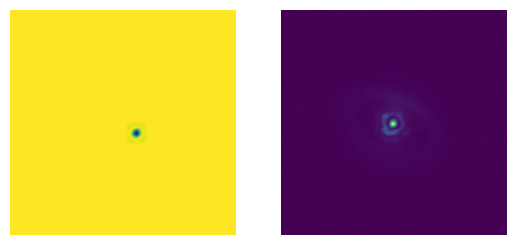

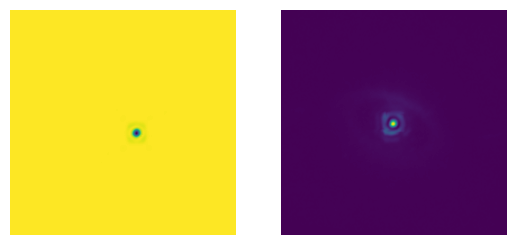

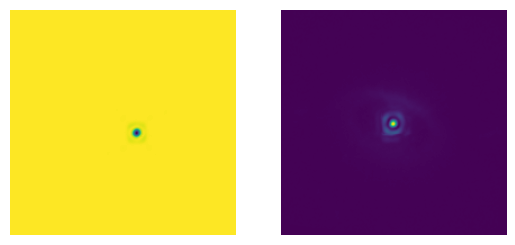

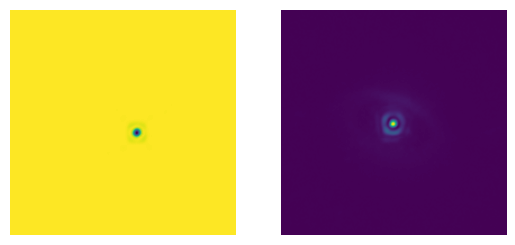

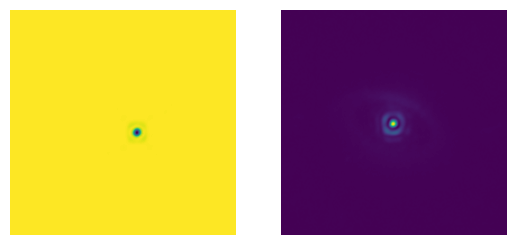

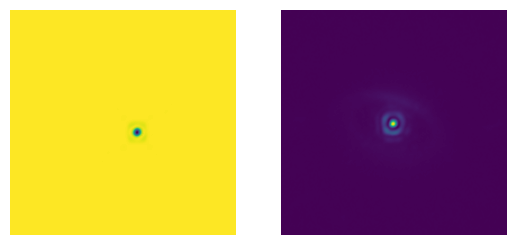

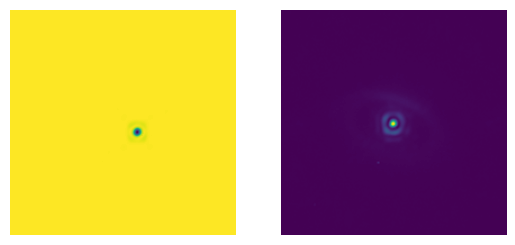

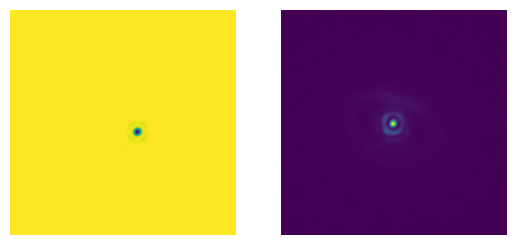

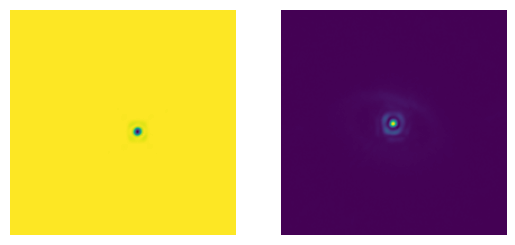

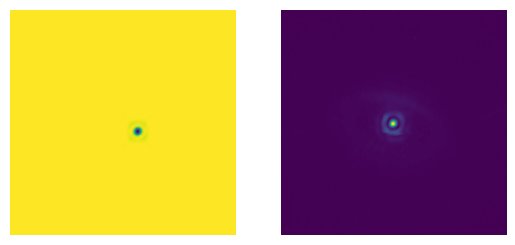

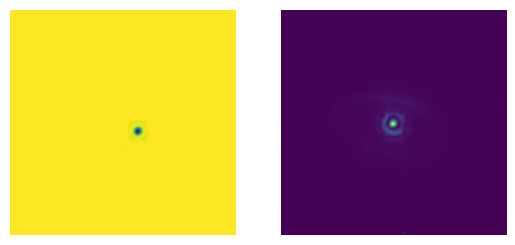

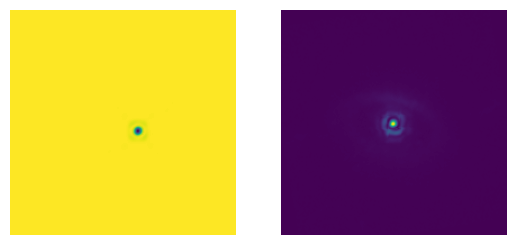

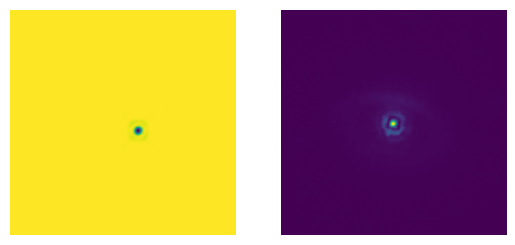

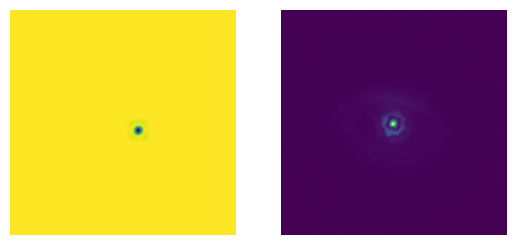

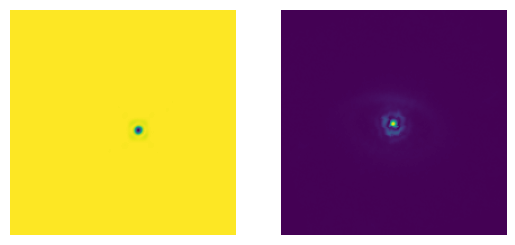

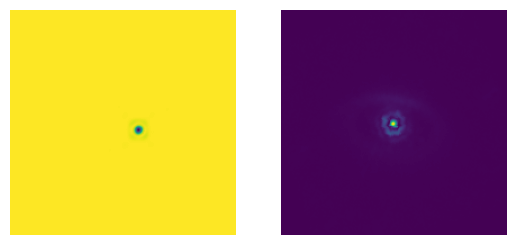

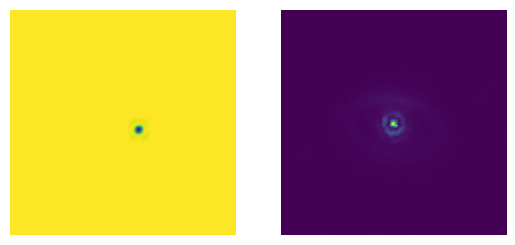

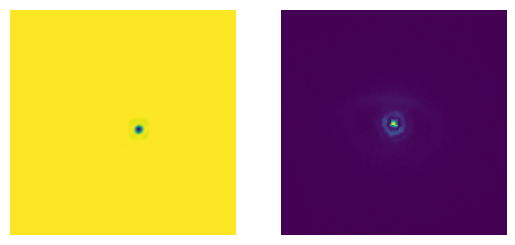

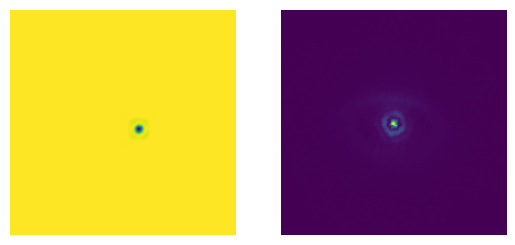

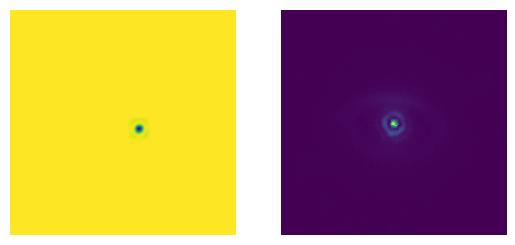

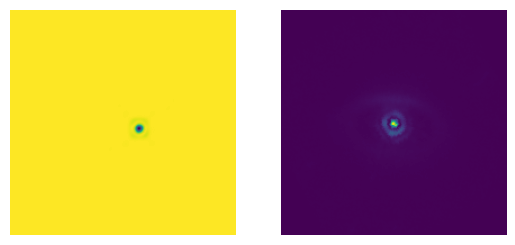

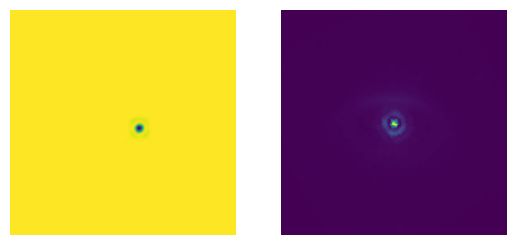

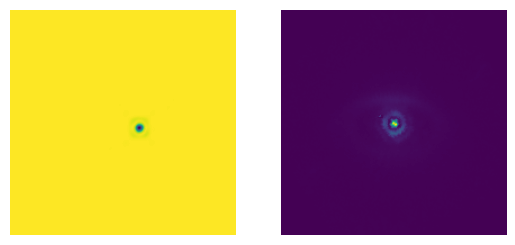

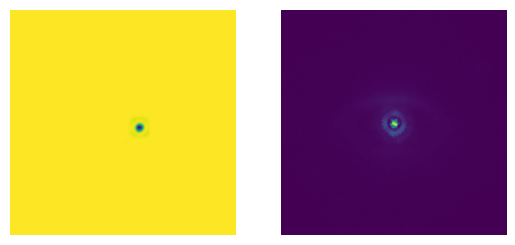

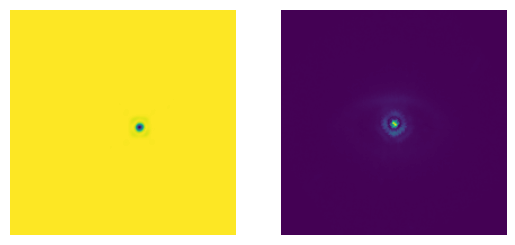

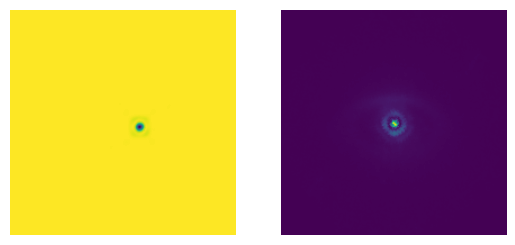

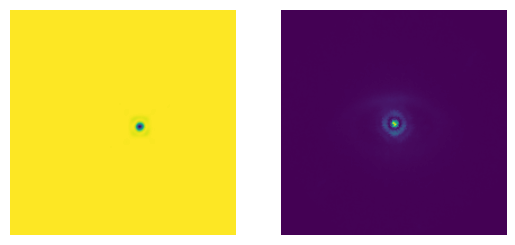

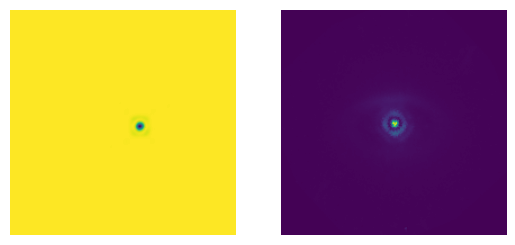

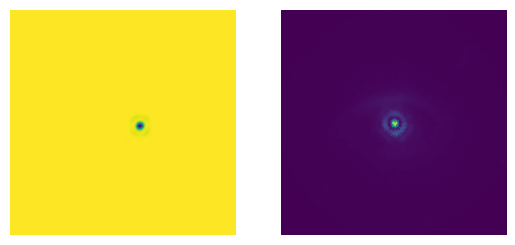

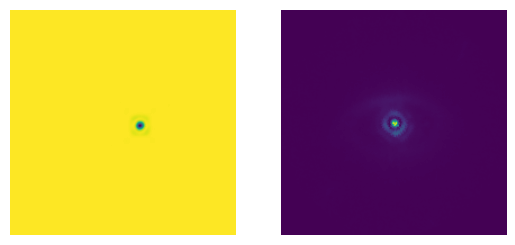

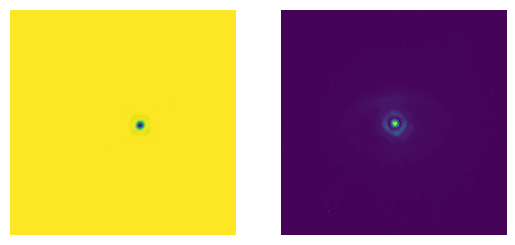

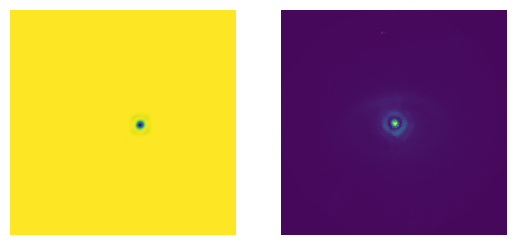

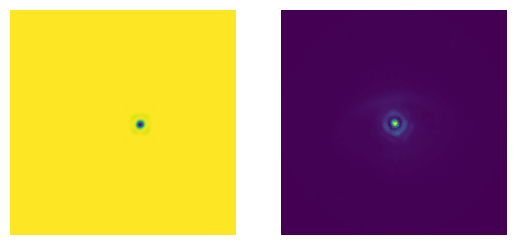

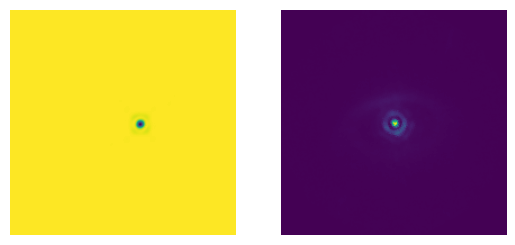

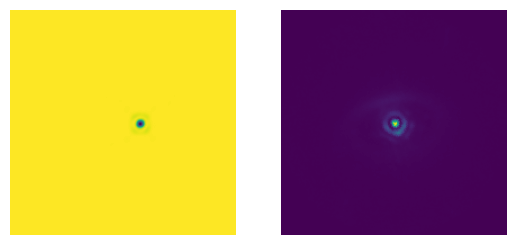

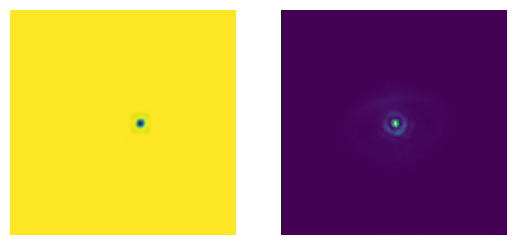

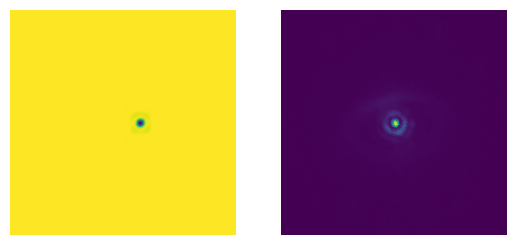

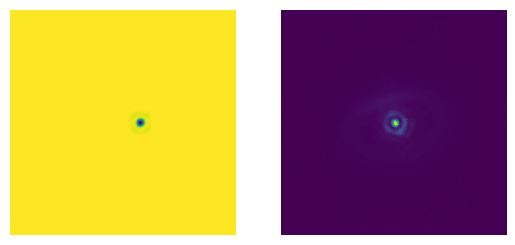

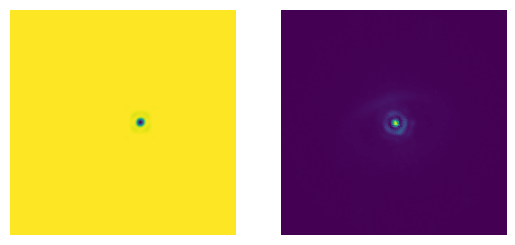

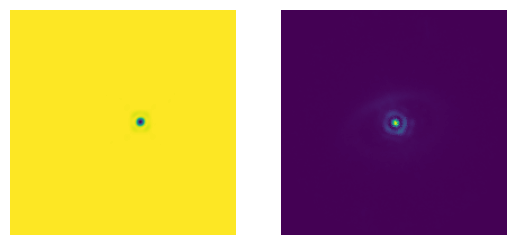

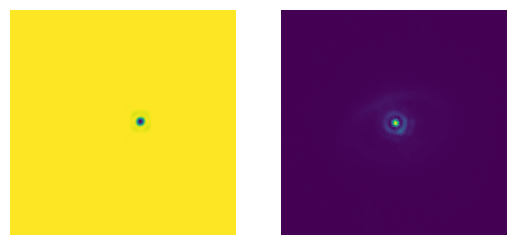

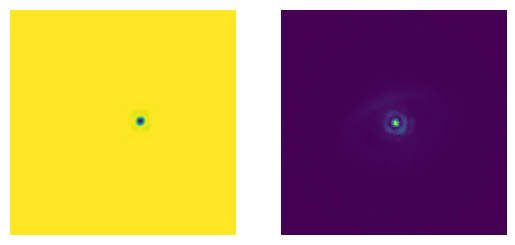

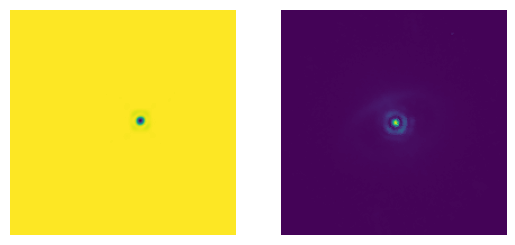

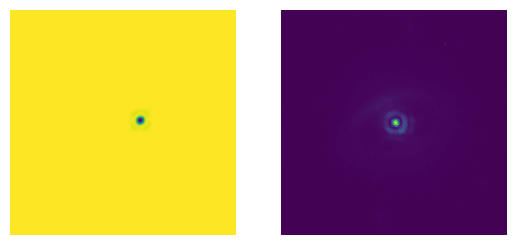

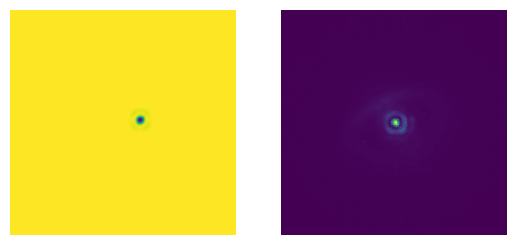

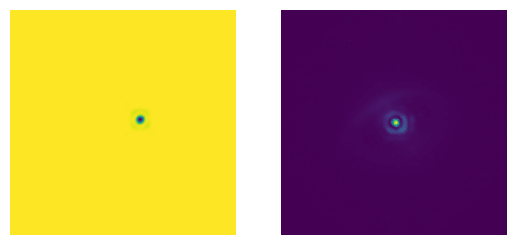

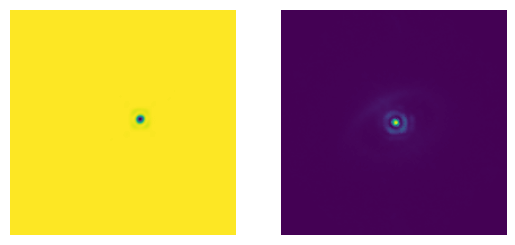

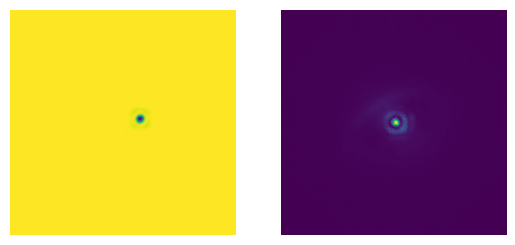

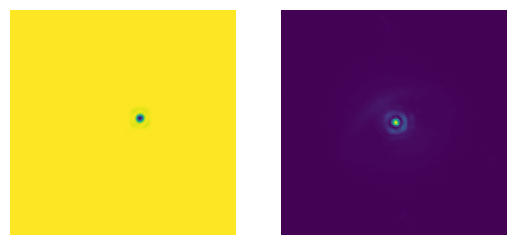

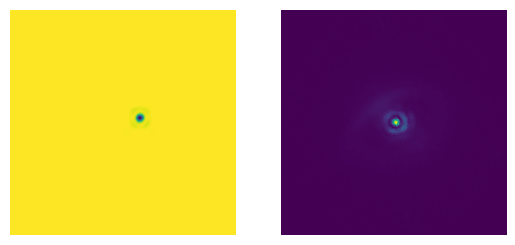

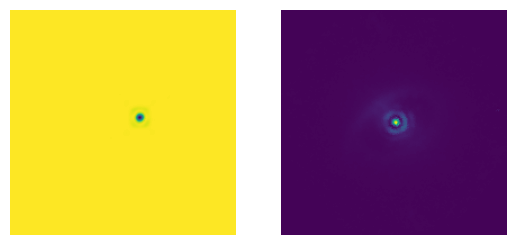

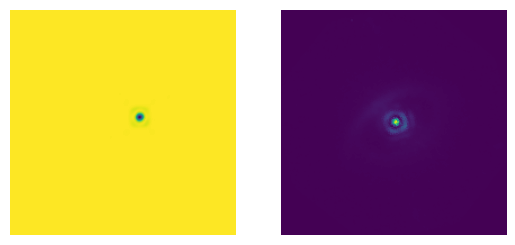

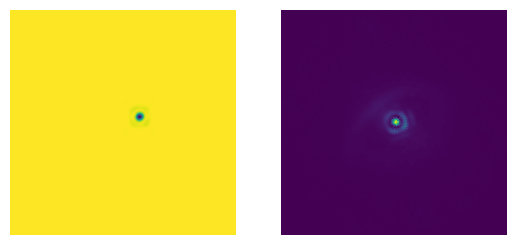

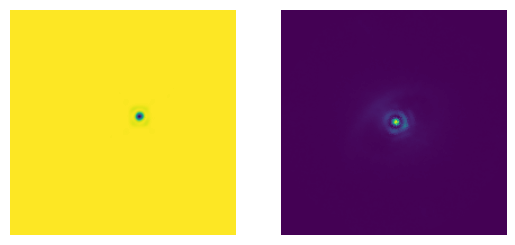

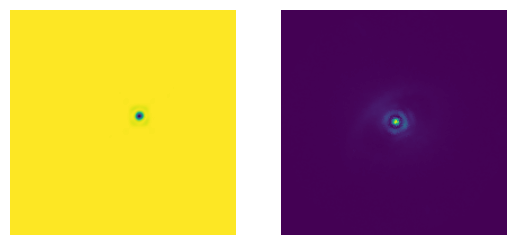

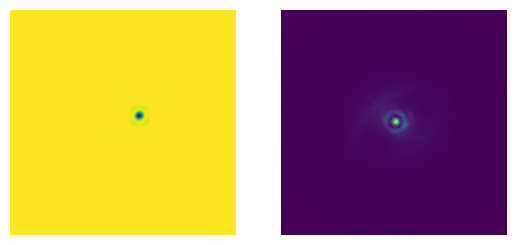

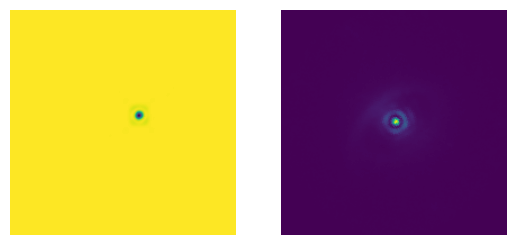

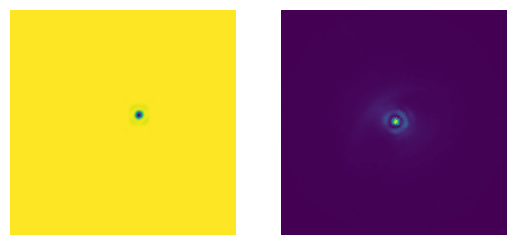

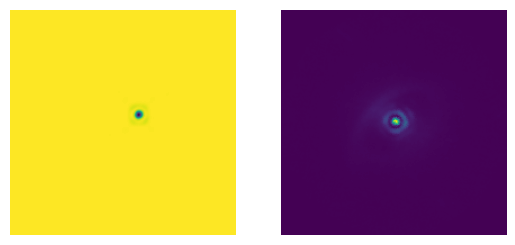

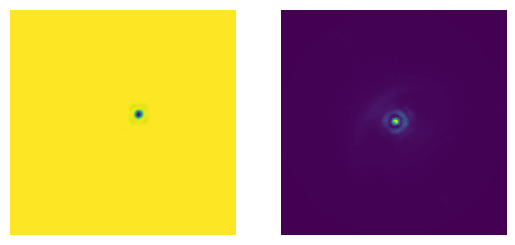

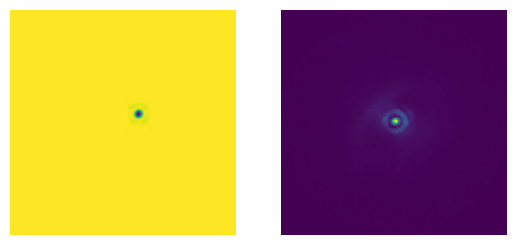

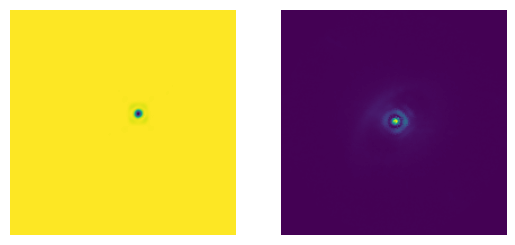

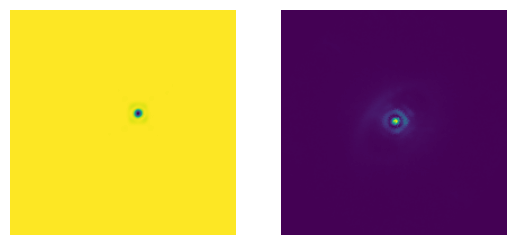

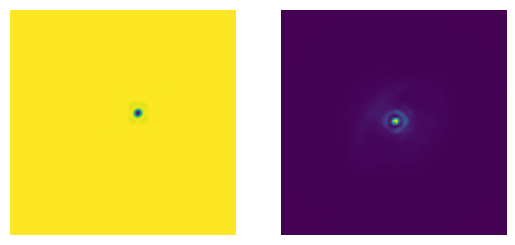

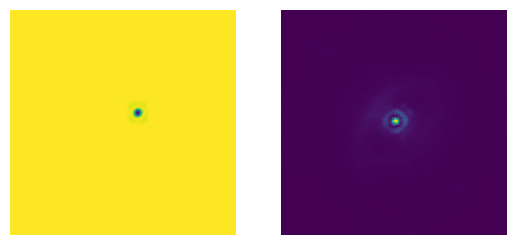

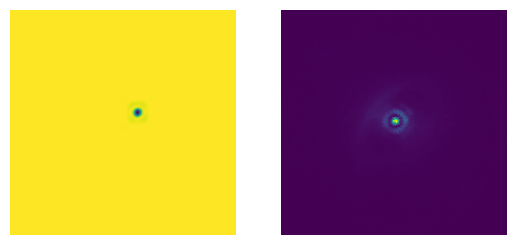

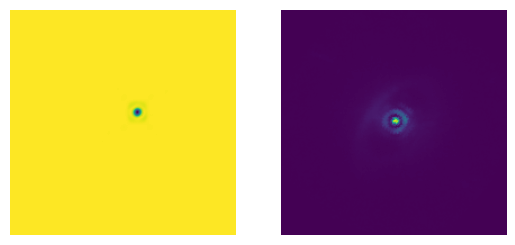

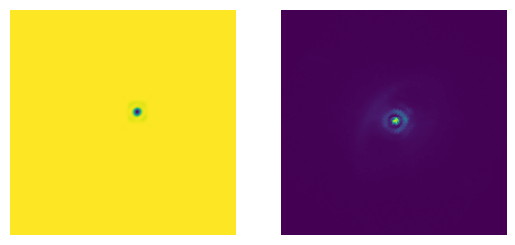

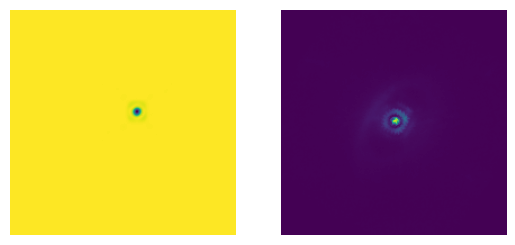

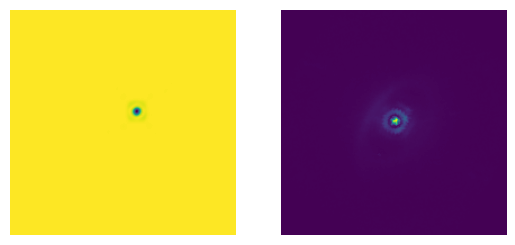

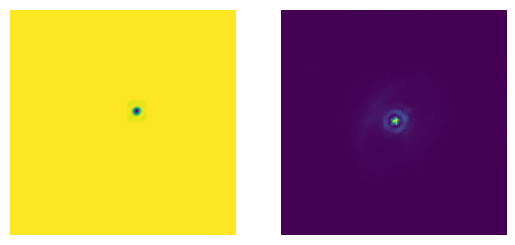

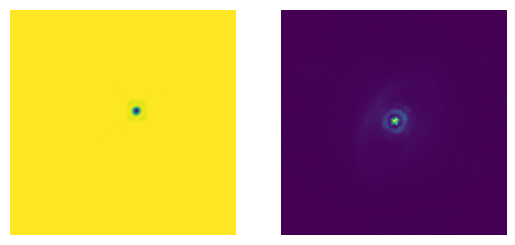

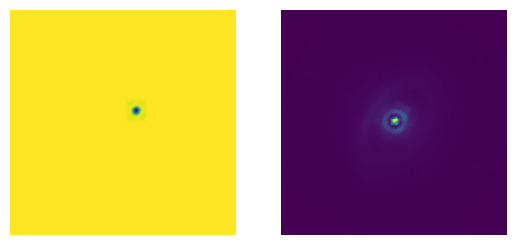

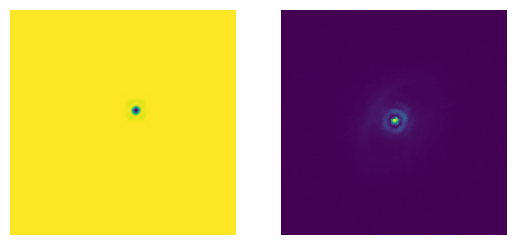

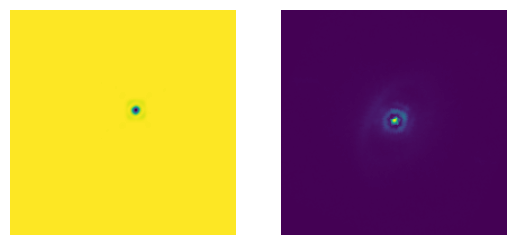

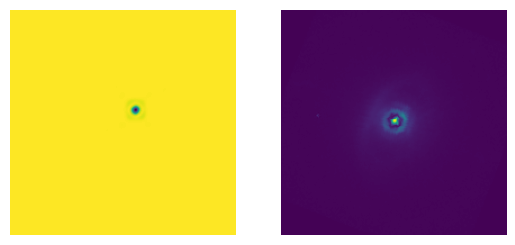

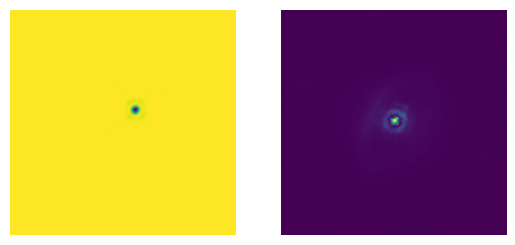

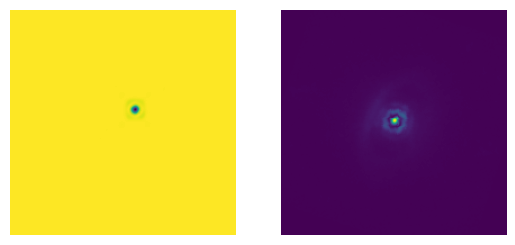

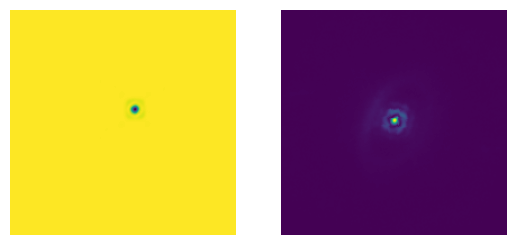

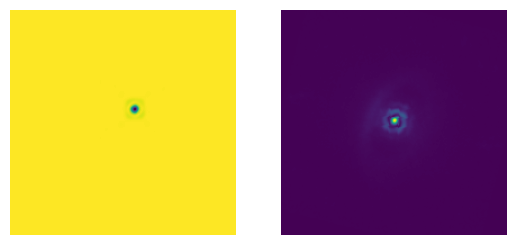

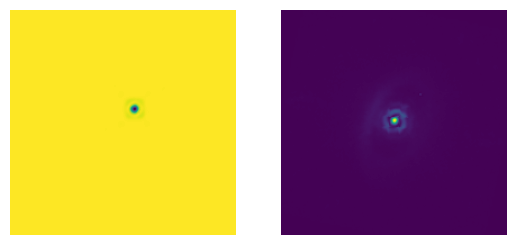

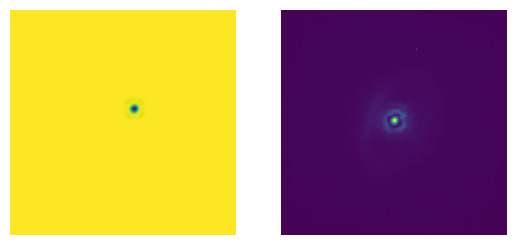

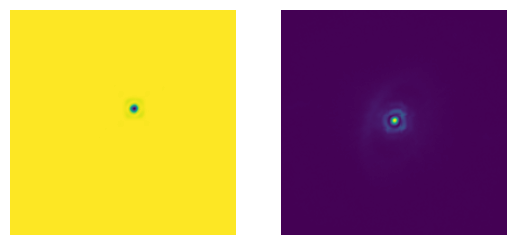

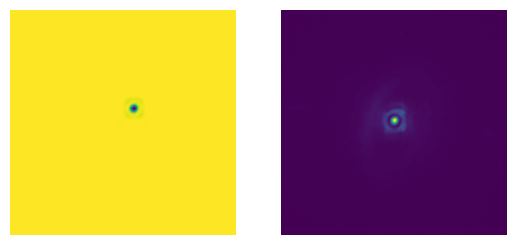

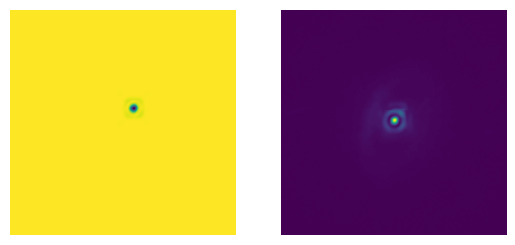

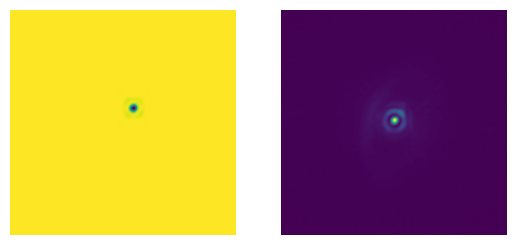

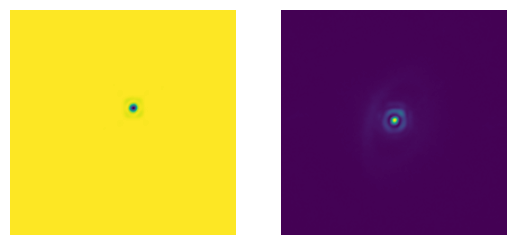

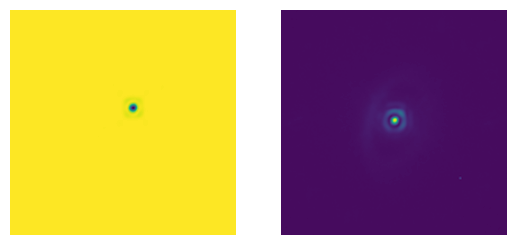

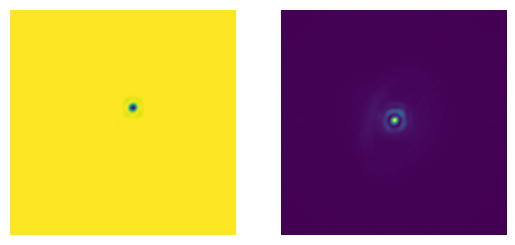

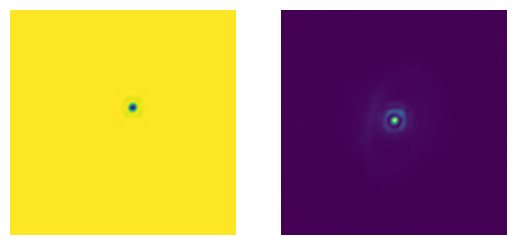

In [245]:
mov_folder = os.path.join(model_path, 'results', 'movement')
os.makedirs(mov_folder, exist_ok=True)
for i in range(injected.shape[0]):
    pad=200
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(injected[i], origin='lower')
    axes[1].imshow(cube_rot[i], origin='lower')
    axes[0].axis('off')
    axes[1].axis('off')
    
    fig.savefig(os.path.join(mov_folder, '{}.png'.format(i)))

In [246]:
%%time
pca_fake = pca_tf(injected, 
                  out_size=cube_rot.shape, 
                  rot_ang=-rot_angles,
                  ncomp=1)

CPU times: user 356 ms, sys: 15.1 ms, total: 371 ms
Wall time: 213 ms


In [247]:
%%time
pca_real = pca_tf(cube_rot, 
                  out_size=cube_rot.shape, 
                  rot_ang=-rot_angles,
                  ncomp=1)

CPU times: user 406 ms, sys: 23.5 ms, total: 429 ms
Wall time: 177 ms


In [248]:
pca_real.shape

TensorShape([201, 201])

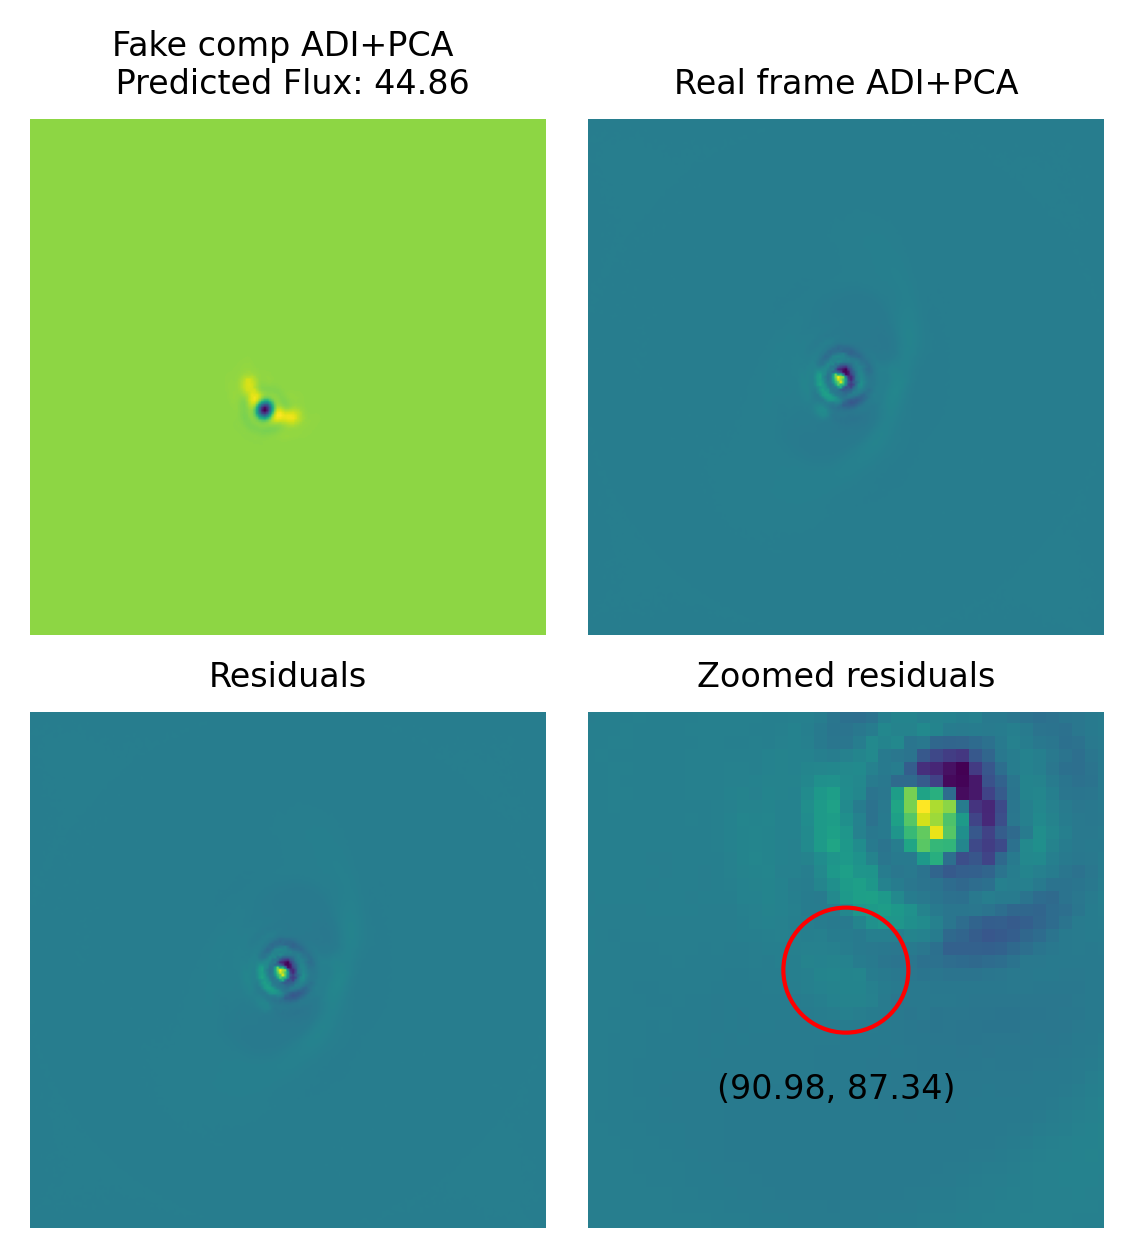

In [249]:
fig, axes = plt.subplots(2, 2,
                        dpi=300, gridspec_kw={'hspace': 0.15, 'wspace': -0.4})
axes = axes.flatten()
axes[0].imshow(pca_fake, origin='lower')
axes[0].set_title('Fake comp ADI+PCA \n Predicted Flux: {:.2f}'.format(mean_flux), fontsize=8)

axes[1].imshow(pca_real, origin='lower')

axes[1].set_title('Real frame ADI+PCA', fontsize=8)

residuals = pca_real+pca_fake
axes[2].imshow(residuals, origin='lower')

axes[2].set_title('Residuals', fontsize=8)

axes[3].imshow(residuals, origin='lower')
axes[3].set_xlim(mean_x-20, mean_x+20)
axes[3].set_ylim(mean_y-20, mean_y+20)
axes[3].scatter(mean_x, mean_y, s=900, facecolors='none', edgecolors='r')
axes[3].set_title('Zoomed residuals', fontsize=8)
axes[3].text(mean_x-10, mean_y-10 , '({:.2f}, {:.2f})'.format(mean_x, mean_y), fontsize=8)
for i in range(4):
    axes[i].axis('off')